
# Title
description

## Section 0 - imports, constants, and notebook set-up

In [1]:
# Library imports
### Utility
import os
from pathlib import Path
from utils import download_dataset, extract_dataset, compute_metrics, trainer_AC, evaluation_run, plot_data_map, Sentences_Dataset, hard_to_learn, cleanline, synonyms, mostsimilar
import urllib
import zipfile
import re

### Datascience
import pandas as pd
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords

### Plotting
import matplotlib.pyplot as plt

# Nltk download
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/angelo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/angelo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/angelo/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/angelo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/angelo/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
# Set of constant used, you can choose which to use below
SEEDS = [42, 69, 420, 42069, 69420]
CARD_DICT = {"sentence":"sentence-transformers/bert-base-nli-mean-tokens",
             "legal":"nlpaueb/legal-bert-small-uncased",
             "tiny":"prajjwal1/bert-tiny"
            }

In [3]:
# Constant setting --- you can change these
SEED_IDX = 0
CARD_KEY = "tiny"
MAX_LEN = 128
TRAIN_BATCH_SIZE = 128
EPOCHS = 30
LEARNING_RATE = 2e-4

In [4]:
# Constant derivation settings --- DO NOT TOUCH
SEED = SEEDS[SEED_IDX]
CARD = CARD_DICT.get(CARD_KEY, "nlpaueb/legal-bert-small-uncased")
torch.manual_seed(SEED)
np.random.seed(SEED);

## Section 1 - Dataset(s) import & manipulation

### 1.1 - Glove Download

In [5]:
# GloVe embedding download
glove_url = "https://nlp.stanford.edu/data/glove.6B.zip"
glove_dir = "glove.6B"
if not os.path.isdir(os.path.join(os.getcwd(), glove_dir)):
    urllib.request.urlretrieve(glove_url, "glove.6B.zip")
    with zipfile.ZipFile("glove.6B.zip", "r") as zip_ref:
        zip_ref.extractall("glove.6B")

    os.remove("glove.6B.zip")

print("GloVe embeddings downloaded and extracted.")

embeddings = {}

for file_name in os.listdir(glove_dir):
    file_path = os.path.join(glove_dir, file_name)

    with open(file_path, 'r', encoding="utf8") as f_glove:
        for line in f_glove:
            entries = line.split()
            wordvector = np.asarray(entries[1:], "float32")
            embeddings[entries[0]] = wordvector

GloVe embeddings downloaded and extracted.


### 1.2 - Import of demosthenes library

In [6]:
url = "https://github.com/engibengi/demosthenes/archive/main.zip"

dataset_name = "demosthenes-main"

dataset_zip_path = Path.cwd().joinpath("demosthenes-main.zip")
dataset_path = Path.cwd().joinpath(dataset_name)

if not dataset_zip_path.exists():
    download_dataset(dataset_zip_path, url)

if not dataset_path.exists():
    extract_dataset(dataset_zip_path, Path.cwd())


### 1.3 - Conversion of xml to json & creation of .pkl datasets

In [7]:
%%capture
%cd ./$dataset_name
%run ./xmlToJson.py # Transform xml dataset into a json one using the dataset utilities
%run ./create_df.py # Create .pkl dataframe from dataset
%cd ./..

### 1.4 - import of .pkl datasets

In [8]:
# annotations = pd.read_pickle(os.path.join(Path.cwd(), dataset_name, 'df_annotations.pkl'))
sentences = pd.read_pickle(os.path.join(Path.cwd(), dataset_name, 'df_sentences.pkl'))

### 1.5 - remove non argumentative sentences

In [9]:
sentences = sentences[sentences['Name'] != 'void']

### 1.6 - Creation of classes and labels in dataframe

In [10]:
labels = sentences.Name.unique()
one_hot = pd.get_dummies(sentences['Name']).astype(float)
sentences.drop(columns=['Name'])
sentences = sentences.join(one_hot)
(sentences, s_test) = train_test_split(sentences)
sentences.reset_index(inplace=True)
s_test.reset_index(inplace=True)

## Section 2 - Model(s) import & set-up

In [11]:
tokenizer = AutoTokenizer.from_pretrained(CARD)
model = AutoModelForSequenceClassification.from_pretrained(CARD, num_labels = len(labels), problem_type='multi_label_classification')
for param in model.bert.embeddings.parameters():
    param.requires_grad = False
for param in model.bert.encoder.parameters():
    param.requires_grad = False
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
optimizer.zero_grad()
loss_fn = torch.nn.BCEWithLogitsLoss()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Section 3 - Model(s) training

In [12]:
dataset = Sentences_Dataset(sentences, tokenizer, labels, max_len=MAX_LEN)
test_dataset = Sentences_Dataset(s_test, tokenizer, labels, max_len=MAX_LEN)
loader = DataLoader(dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=False, pin_memory=True)

In [13]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-1): 2 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=128, out_features=128, bias=True)
              (LayerNorm): LayerNorm((128,), eps=1e-12, e

In [14]:
train_dyn={}

### Training

In [15]:
history = trainer_AC(model, device, optimizer, loss_fn, loader, EPOCHS*3, train_dyn)

EPOCH 1/90...
Generation of samples for data cartography...
EPOCH 2/90...
Generation of samples for data cartography...
EPOCH 3/90...
Generation of samples for data cartography...
EPOCH 4/90...
Generation of samples for data cartography...
EPOCH 5/90...
Generation of samples for data cartography...
EPOCH 6/90...
Generation of samples for data cartography...
EPOCH 7/90...
Generation of samples for data cartography...
EPOCH 8/90...
Generation of samples for data cartography...
EPOCH 9/90...
Generation of samples for data cartography...
EPOCH 10/90...
Generation of samples for data cartography...
EPOCH 11/90...
Generation of samples for data cartography...
EPOCH 12/90...
Generation of samples for data cartography...
EPOCH 13/90...
Generation of samples for data cartography...
EPOCH 14/90...
Generation of samples for data cartography...
EPOCH 15/90...
Generation of samples for data cartography...
EPOCH 16/90...
Generation of samples for data cartography...
EPOCH 17/90...
Generation of samp

## Section 4 - Model(s) evaluation

In [16]:
model.eval()
results = evaluation_run(model, test_loader, device)
results = pd.DataFrame(results, columns=labels)
print(classification_report(s_test[labels], results, target_names=labels, zero_division=0.0))

              precision    recall  f1-score   support

        prem       0.98      0.99      0.99       589
        conc       0.85      0.70      0.77        40

   micro avg       0.97      0.97      0.97       629
   macro avg       0.91      0.85      0.88       629
weighted avg       0.97      0.97      0.97       629
 samples avg       0.97      0.97      0.97       629



## Section 5 - PLOT DATA CARTOGRAHPY

In [17]:
cartography=compute_metrics(train_dyn)
sentences = sentences.join(cartography)

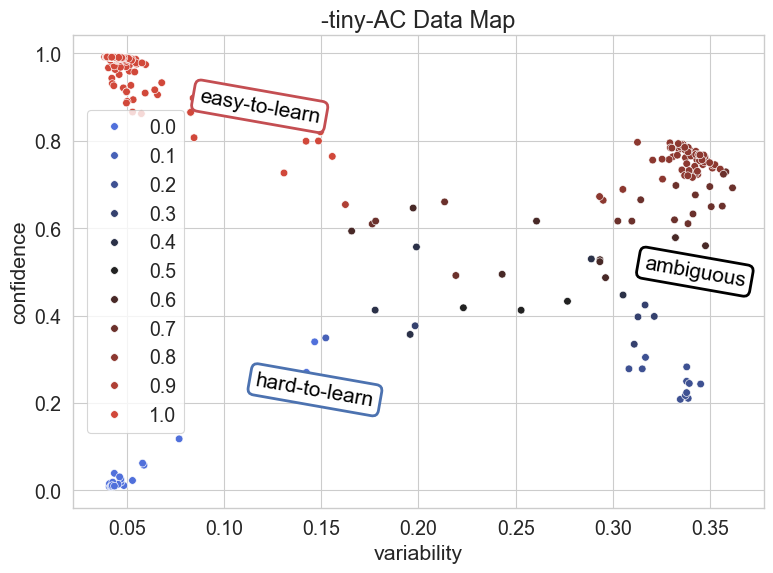

In [18]:
plot_data_map(cartography,plot_dir=os.getcwd(),show_hist=False, model=CARD_KEY+"-AC")

## Section 6 - Curriculum Learning

### Create the new datasets and dataloaders

In [19]:
new_col = pd.DataFrame(sentences['confidence'] * (1 - sentences['variability']), columns = ['c*(1-v)'])
sentences = sentences.join(new_col)
datasets_curriculum = [
    sentences[sentences['c*(1-v)'] >= sentences['c*(1-v)'].quantile(i/10)].reset_index(drop=True, inplace=False)
    for i in range(9, -1, -1)
    ]
datasets_curriculum = [Sentences_Dataset(ds, tokenizer, labels, max_len=MAX_LEN) for ds in datasets_curriculum]
loaders_curriculum = [DataLoader(ds, batch_size=TRAIN_BATCH_SIZE, shuffle=True, pin_memory=True) for ds in datasets_curriculum]

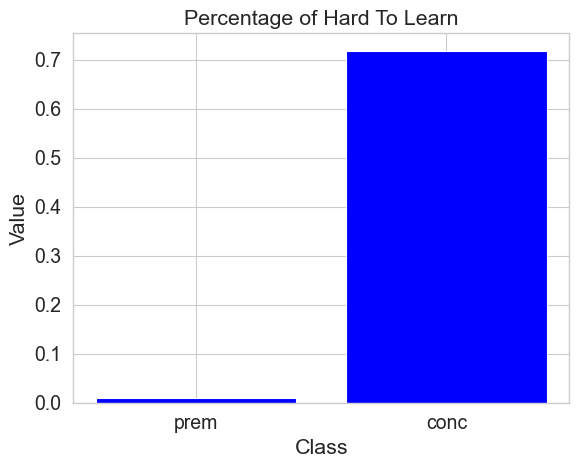

In [20]:
hard_to_learn(sentences, labels=labels, threshold=0.5)

### Create the new model

In [21]:
model2 = AutoModelForSequenceClassification.from_pretrained(CARD, num_labels = len(labels), problem_type='multi_label_classification')
for param in model2.bert.embeddings.parameters(): # We don't want to train the first layer
    param.requires_grad = False
for param in model2.bert.encoder.parameters():
    param.requires_grad = False
optimizer = torch.optim.AdamW(model2.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
optimizer.zero_grad()
loss_fn = torch.nn.BCEWithLogitsLoss()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model2.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-1): 2 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=128, out_features=128, bias=True)
              (LayerNorm): LayerNorm((128,), eps=1e-12, e

### Train with curriculum learning

In [23]:
history2 = []
train_dyn2 = {}
for i,loader in enumerate(loaders_curriculum):
    history2.extend(trainer_AC(model2, device, optimizer, loss_fn, loader, EPOCHS//((11-i)//2), train_dyn2))
history2.extend(trainer_AC(model2, device, optimizer, loss_fn, loaders_curriculum[-1], EPOCHS, train_dyn2))

EPOCH 1/6...
Generation of samples for data cartography...
EPOCH 2/6...
Generation of samples for data cartography...
EPOCH 3/6...
Generation of samples for data cartography...
EPOCH 4/6...
Generation of samples for data cartography...
EPOCH 5/6...
Generation of samples for data cartography...
EPOCH 6/6...
Generation of samples for data cartography...
EPOCH 1/6...
Generation of samples for data cartography...
EPOCH 2/6...
Generation of samples for data cartography...
EPOCH 3/6...
Generation of samples for data cartography...
EPOCH 4/6...
Generation of samples for data cartography...
EPOCH 5/6...
Generation of samples for data cartography...
EPOCH 6/6...
Generation of samples for data cartography...
EPOCH 1/7...
Generation of samples for data cartography...
EPOCH 2/7...
Generation of samples for data cartography...
EPOCH 3/7...
Generation of samples for data cartography...
EPOCH 4/7...
Generation of samples for data cartography...
EPOCH 5/7...
Generation of samples for data cartography.

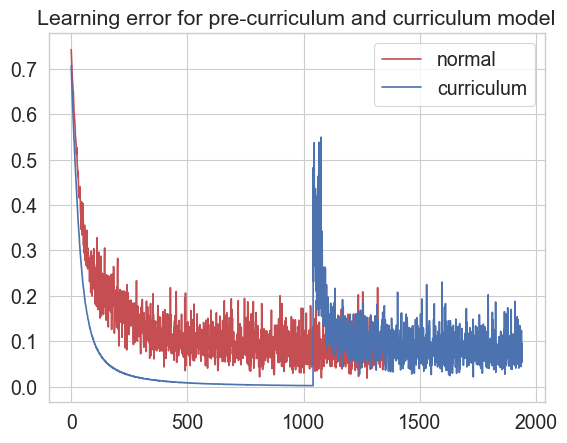

In [24]:
plt.plot(history, c='r')
plt.plot(history2, c='b')
plt.title("Learning error for pre-curriculum and curriculum model")
plt.legend(['normal', 'curriculum'])
plt.grid(True)
plt.show();

In [25]:
results2 = evaluation_run(model2, test_loader, device)
results2 = pd.DataFrame(results2, columns=labels)
print(classification_report(s_test[labels], results2, target_names=labels, zero_division=0.0))

              precision    recall  f1-score   support

        prem       0.98      0.99      0.99       589
        conc       0.85      0.70      0.77        40

   micro avg       0.97      0.97      0.97       629
   macro avg       0.91      0.85      0.88       629
weighted avg       0.97      0.97      0.97       629
 samples avg       0.97      0.97      0.97       629



## Section 7 - Data Augmentation on hard to learn

In [26]:
# Filter rows based on conditions (Name is 'prem' and Type is 'L')
filtered_dfac = sentences[(sentences['c*(1-v)']<=0.5)]

# Extract the 'Text' column from the filtered DataFrame
name_column_ac = filtered_dfac['Name'].reset_index(drop=True)
text_column_ac = filtered_dfac['Text'].reset_index(drop=True)
conc_column_ac = filtered_dfac['conc'].reset_index(drop=True)
prem_column_ac = filtered_dfac['prem'].reset_index(drop=True)
conf_column_ac = filtered_dfac['confidence'].reset_index(drop=True)
var_column_ac = filtered_dfac['variability'].reset_index(drop=True)
corr_column_ac = filtered_dfac['correctness'].reset_index(drop=True)
cv_column_ac = filtered_dfac['c*(1-v)'].reset_index(drop=True)

text_column_ac.to_csv('output_ac.txt', index=False, header=False, sep='\t')

TRAINSETPATHX=str(Path.cwd().joinpath('output_ac.txt'))

f=open(TRAINSETPATHX,'r',encoding='utf8')
maximbits_ac=f.readlines()
f.close()
#removing the endline characters
maximbits_ac=[maxim[:-1] for maxim in maximbits_ac]

print("The number of maxims for ac: {}".format(len(maximbits_ac)))

The number of maxims for ac: 103


In [27]:
#breaking th maxim lines into sentences
sentences_ac = []
nsentence_ac = []  #storing the number of sentences each maxim contains
for line in maximbits_ac:
    count = 0
    #splitting sentences using ". " characters
    #listsent=line.replace('\\\n','').split('. ')
    listsent = line.split('. ')
    for i in range(0, len(listsent)):
        sentence_ac = listsent[i]
        #sentences that are too short are eliminated
        if len(sentence_ac) < 5:
            continue
        elif (i == len(listsent) - 1):
            #the last one is added as it is since we used the character sequence ". " for the seperation
            #and the last sentence contains only "."
            sentences_ac.append(sentence_ac)
            count = count + 1
            continue
        else:
            #the "." characters are restored
            if (sentence_ac[-1] != '.'):
                sentence_ac = sentence_ac + '.'
            sentences_ac.append(sentence_ac)
            count = count + 1
    nsentence_ac.append(count)

print(len(sentences_ac))
print(len(nsentence_ac))

103
103


In [28]:
perfix=[0.6] #percentage desired
noisesent6=[]
S=[]
for sent in sentences_ac:
    if sentences_ac.index(sent)%100==0:
      print(sentences_ac.index(sent))
    #tokinizing and capitalizing the sentences
    tokens = nltk.word_tokenize(cleanline(sent).capitalize())
    #lower-casing the tokens
    tokens=[token.lower() for token in tokens]
    #eliminating the stop words
    nonstoptoken = [word for word in tokens if not word in stop_words]
    tags = nltk.pos_tag(nonstoptoken)
    #collecting the tokens with POS tag in categories nouns, adjectives and adverbs
    tochange=[tag for tag in tags if tag[1][0] in ['J','N','R']]
    nchange=[round(per*len(tochange)) for per in perfix] #number of required replacements due to the percentage given
    #print("Len to change: {}".format(len(tochange)))
    #print("Nchange: {}".format(nchange[0]))
    linemodtotal=sent.lower()
    indicator=sent[0].isupper()
    changed=0
    #adding the sentences into list if no change is supposed to be performed
    if nchange[0]==0:
        if (indicator):
            toadd=linemodtotal.capitalize()
        else:
            toadd=linemodtotal
        noisesent6.append(toadd)
    index=-1
    #random.shuffle(tochange)
    while(changed<nchange[-1]):
        index+=1
        if(index==len(tochange)):
            if changed<nchange[0]:
              if (indicator):
                  toadd=linemodtotal.replace('#','').capitalize()
              else:
                  toadd=linemodtotal.replace('#','')
              noisesent6.append(toadd)
            break
        word=tochange[index][0]
        #print("Word to change: {}".format(word))
        #Obtaining the candidates for the replacement
        [wn,check2]=synonyms(tochange[index][0],10)
        #if the list is not empty:
        if (check2):
            toreplace=mostsimilar(embeddings,word,wn)
            #word is replaced with the candidate accompanying "#" characters as boundaries
            #this is done to prevent the replacement of the in-word and multiple occurences of the words in process
            pattern='(?<![a-zA-Z#])'+word+'(?![a-zA-Z#])'
            linemodtotal=re.sub(pattern,'#'+toreplace+'#',linemodtotal,1)
            #print(linemodtotal)
            changed+=1
        else:
            continue
        #if the desired number of words are replaced
        if changed==nchange[0]:
            #indicator serves as a sign of the capitalized sentence
            #the "#" characters are removed at the end
            if (indicator):
                toadd=linemodtotal.replace('#','').capitalize()
            else:
                toadd=linemodtotal.replace('#','')
            #the augmented sentences added to the list defined at the beginning
            noisesent6.append(toadd)
            break

0
100


In [29]:
FINALPATH=str(Path.cwd())

noiselist=[noisesent6]
for element in noiselist:
    folder="0.6" #Could also be iterated due to percentages. Here we use only one percentage value therefore it is strictly defined
    final=[]
    start=0
    for i in range(0,len(nsentence_ac)):
        toaddm=''
        n=nsentence_ac[i]
        #merging the sentences that are contained in the same maxim
        for j in range(start,start+n):
            toaddm=toaddm+' '+element[j]
        toaddm=toaddm[1:]
        final.append(toaddm)
        start=start+n
    #saving the augmented samples into a text document in the given final path
    f=open(FINALPATH+'/maximsamples_wordnetglove_ac'+folder[-1]+'0.txt', 'w',encoding="utf8")
    for line in final:
        f.write(line+'\n')
    f.close()

txt_file_path = "maximsamples_wordnetglove_ac60.txt"

with open(txt_file_path, 'r', encoding='utf-8') as file:
    new_texts = file.readlines()
for k in range(len(new_texts)):
    new_row = pd.DataFrame({
        'Document': ['new'],
        'Split': [1],
        'Name': [name_column_ac[k]],
        'Text': [new_texts[k]],
        'prem': [prem_column_ac[k]],
        'conc': [conc_column_ac[k]],
        'confidence': [conf_column_ac[k]],
        'variability': [var_column_ac[k]],
        'correctness': [corr_column_ac[k]],
        'c*(1-v)': [cv_column_ac[k]]
    })
    sentences = pd.concat([sentences, new_row], ignore_index=True)

sentences.to_pickle("updated_df_ac.pkl")

In [30]:
datasets_curriculum = [
    sentences[sentences['c*(1-v)'] >= sentences['c*(1-v)'].quantile(i/10)].reset_index(drop=True, inplace=False)
    for i in range(9, -1, -1)
    ]
datasets_curriculum = [Sentences_Dataset(ds, tokenizer, labels, max_len=MAX_LEN) for ds in datasets_curriculum]
loaders_curriculum = [DataLoader(ds, batch_size=TRAIN_BATCH_SIZE, shuffle=True, pin_memory=True) for ds in datasets_curriculum]

## Section 8 - Model with Data Augmentation and curriculum learning

In [31]:
model3 = AutoModelForSequenceClassification.from_pretrained(CARD, num_labels = len(labels), problem_type='multi_label_classification')
for param in model3.bert.embeddings.parameters(): # We don't want to train the first layer
    param.requires_grad = False
for param in model3.bert.encoder.parameters():
    param.requires_grad = False
optimizer = torch.optim.AdamW(model3.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
optimizer.zero_grad()
loss_fn = torch.nn.BCEWithLogitsLoss()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model3.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-1): 2 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=128, out_features=128, bias=True)
              (LayerNorm): LayerNorm((128,), eps=1e-12, e

In [33]:
history3 = []
train_dyn3 = {}
for i,loader in enumerate(loaders_curriculum):
    history3.extend(trainer_AC(model3, device, optimizer, loss_fn, loader, EPOCHS//((11-i)//2), train_dyn3))
history3.extend(trainer_AC(model3, device, optimizer, loss_fn, loaders_curriculum[-1], EPOCHS, train_dyn3))

EPOCH 1/6...
Generation of samples for data cartography...
EPOCH 2/6...
Generation of samples for data cartography...
EPOCH 3/6...
Generation of samples for data cartography...
EPOCH 4/6...
Generation of samples for data cartography...
EPOCH 5/6...
Generation of samples for data cartography...
EPOCH 6/6...
Generation of samples for data cartography...
EPOCH 1/6...
Generation of samples for data cartography...
EPOCH 2/6...
Generation of samples for data cartography...
EPOCH 3/6...
Generation of samples for data cartography...
EPOCH 4/6...
Generation of samples for data cartography...
EPOCH 5/6...
Generation of samples for data cartography...
EPOCH 6/6...
Generation of samples for data cartography...
EPOCH 1/7...
Generation of samples for data cartography...
EPOCH 2/7...
Generation of samples for data cartography...
EPOCH 3/7...
Generation of samples for data cartography...
EPOCH 4/7...
Generation of samples for data cartography...
EPOCH 5/7...
Generation of samples for data cartography.

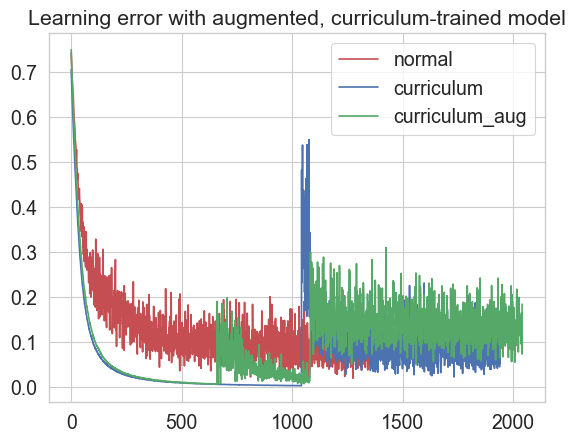

In [34]:
plt.plot(history, c='r')
plt.plot(history2, c='b')
plt.plot(history3, c='g')
plt.legend(['normal', 'curriculum', 'curriculum_aug'])
plt.title("Learning error with augmented, curriculum-trained model")
plt.grid(True)
plt.show();

In [41]:
results3 = evaluation_run(model3, test_loader, device)
results3 = pd.DataFrame(results3, columns=labels)
print(classification_report(s_test[labels], results3, target_names=labels, zero_division=0.0))

              precision    recall  f1-score   support

        prem       0.98      0.99      0.99       589
        conc       0.85      0.70      0.77        40

   micro avg       0.97      0.97      0.97       629
   macro avg       0.91      0.85      0.88       629
weighted avg       0.97      0.97      0.97       629
 samples avg       0.97      0.97      0.97       629



## Section 9 - Model with only Data Augmentation

In [36]:
model4 = AutoModelForSequenceClassification.from_pretrained(CARD, num_labels = len(labels), problem_type='multi_label_classification')
for param in model4.bert.embeddings.parameters(): # We don't want to train the first layer
    param.requires_grad = False
for param in model4.bert.encoder.parameters():
    param.requires_grad = False
optimizer = torch.optim.AdamW(model4.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
optimizer.zero_grad()
loss_fn = torch.nn.BCEWithLogitsLoss()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [37]:
dataset_aug = Sentences_Dataset(sentences, tokenizer, labels, max_len=MAX_LEN)
loader_aug = DataLoader(dataset_aug, batch_size=TRAIN_BATCH_SIZE, shuffle=True, pin_memory=True)

In [38]:
train_dyn4 = {}
history4 = trainer_AC(model4, device, optimizer, loss_fn, loader, EPOCHS*3, train_dyn4)

EPOCH 1/90...
Generation of samples for data cartography...
EPOCH 2/90...
Generation of samples for data cartography...
EPOCH 3/90...
Generation of samples for data cartography...
EPOCH 4/90...
Generation of samples for data cartography...
EPOCH 5/90...
Generation of samples for data cartography...
EPOCH 6/90...
Generation of samples for data cartography...
EPOCH 7/90...
Generation of samples for data cartography...
EPOCH 8/90...
Generation of samples for data cartography...
EPOCH 9/90...
Generation of samples for data cartography...
EPOCH 10/90...
Generation of samples for data cartography...
EPOCH 11/90...
Generation of samples for data cartography...
EPOCH 12/90...
Generation of samples for data cartography...
EPOCH 13/90...
Generation of samples for data cartography...
EPOCH 14/90...
Generation of samples for data cartography...
EPOCH 15/90...
Generation of samples for data cartography...
EPOCH 16/90...
Generation of samples for data cartography...
EPOCH 17/90...
Generation of samp

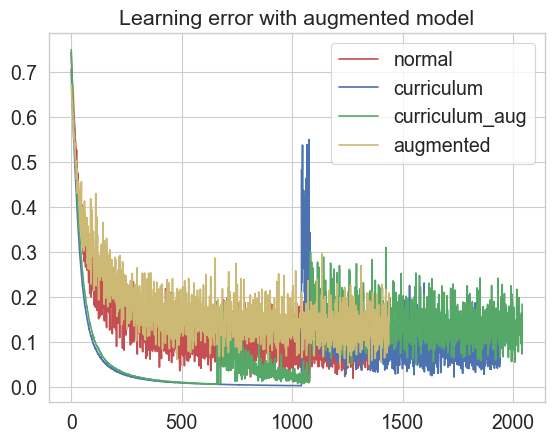

In [39]:
plt.plot(history, c='r')
plt.plot(history2, c='b')
plt.plot(history3, c='g')
plt.plot(history4, c='y')
plt.legend(['normal', 'curriculum', 'curriculum_aug', 'augmented'])
plt.title("Learning error with augmented model")
plt.grid(True)
plt.show();

In [42]:
results4 = evaluation_run(model4, test_loader, device)
results4 = pd.DataFrame(results4, columns=labels)
print(classification_report(s_test[labels], results4, target_names=labels, zero_division=0.0))

              precision    recall  f1-score   support

        prem       0.98      0.99      0.98       589
        conc       0.82      0.70      0.76        40

   micro avg       0.97      0.97      0.97       629
   macro avg       0.90      0.84      0.87       629
weighted avg       0.97      0.97      0.97       629
 samples avg       0.97      0.97      0.97       629

